### New strain of AI prompts - refresh to try and improve outputs. 
#### USER INPUT:
This is my code for creating probability density
 function (Paste.txt)  - now using the same parameters
 LOS_PARAMS and ADMISSION_RATES_AS create
 a simulated trade off between the probability that
 a patient is delayed (p(delay)) and the number of
 bed available in the acute unit. the p delay should
 be calcualted using PDF and CDF and use the
 erlang formula p(delay)=PN
 ≤
 n)PN=n. the graph
 should have no of acute beds on x axis and span
 from 028 it should be a stepwise figure

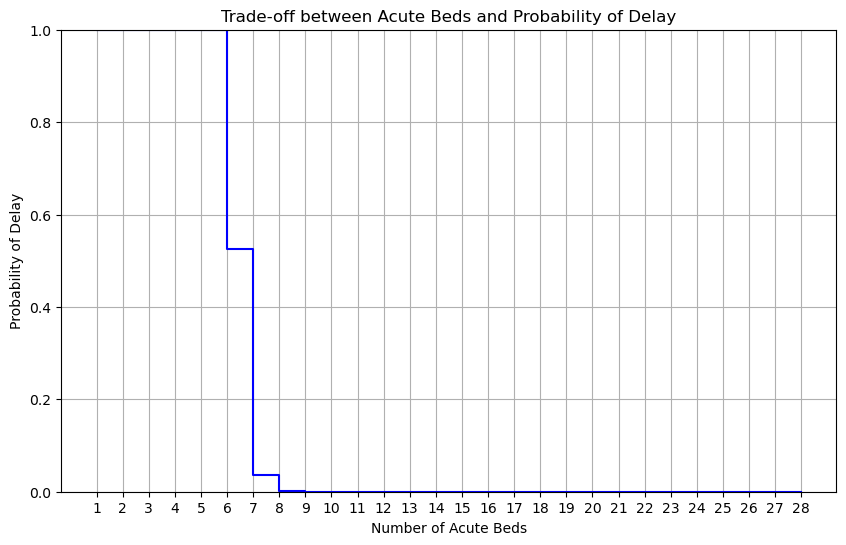

In [1]:
import simpy
import random
import math
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson

# Initialize simulation environment
env = simpy.Environment()

# Create units with effectively unlimited capacity
# ACUTE_STROKE_UNIT = simpy.Resource(env, capacity=1000000)
REHAB_UNIT = simpy.Resource(env, capacity=1000000)

# Updated lognormal distribution parameters for ASU length of stay
LOS_PARAMS = {
    'Stroke-rehab': {'mu': 1.574, 'sigma': 0.924},
    'Stroke-ESD': {'mu': 1.158, 'sigma': 0.858},
    'Stroke-other': {'mu': 1.479, 'sigma': 0.966},
    'TIA': {'mu': 0.104, 'sigma': 0.984},
    'Complex Neurological': {'mu': 0.916, 'sigma': 0.970},
    'Other': {'mu': 0.807, 'sigma': 1.027}
}

# Mean admission rates (days between arrivals) to the ASU
ADMISSION_RATES_ASU = {
    'Stroke': 1.2,
    'TIA': 9.3,
    'Complex Neurological': 3.6,
    'Other': 3.2
}

# Mean admission rates to the RU
ADMISSION_RATES_RU = {
    'Stroke': 21.8,
    'Complex Neurological': 31.7,
    'Other': 28.6
}

# Apply 5% increase to admission rates for Scenario 1
ADMISSION_RATES_ASU = {k: v * 0.95 for k, v in ADMISSION_RATES_ASU.items()}
ADMISSION_RATES_RU = {k: v * 0.95 for k, v in ADMISSION_RATES_RU.items()}

# Discharge probabilities from ASU
PATIENT_DISCHARGE_PROB = {
    'Stroke': {
        'RU': 0.24,  # Stroke-rehab
        'ESD': 0.13,  # Stroke-ESD
        'Other': 0.63  # Stroke-other
    },
    'TIA': {
        'RU': 0.01,
        'ESD': 0.01,
        'Other': 0.98
    },
    'Complex Neurological': {
        'RU': 0.11,
        'ESD': 0.05,
        'Other': 0.84
    },
    'Other': {
        'RU': 0.05,
        'ESD': 0.10,
        'Other': 0.85
    }
}

# RU discharge probabilities
RU_DISCHARGE_PROB = {
    'Stroke': {'ESD': 0.40, 'Other': 0.60},
    'TIA': {'ESD': 0.00, 'Other': 1.00},
    'Complex Neurological': {'ESD': 0.09, 'Other': 0.91},
    'Other': {'ESD': 0.12, 'Other': 0.88}
}

# Updated lognormal distribution parameters for RU length of stay
RU_LOS_PARAMS = {
    'Stroke-Other': {'mu': 3.021, 'sigma': 0.807},
    'Stroke-ESD': {'mu': 3.182, 'sigma': 0.677},
    'Complex Neurological': {'mu': 2.957, 'sigma': 0.850},
    'Other': {'mu': 2.494, 'sigma': 0.755},
    'TIA': {'mu': 2.455, 'sigma': 0.973}
}

# Track occupancy data
occupancy_data = {
    'asu_daily': [],
    'ru_daily': []
}

def get_los(patient_type, unit='ASU'):
    """Generate lognormal length of stay based on patient type and unit"""
    if unit == 'ASU':
        params = LOS_PARAMS[patient_type]
    else:  # unit == 'RU'
        params = RU_LOS_PARAMS[patient_type]
    return max(0.1, lognorm.rvs(s=params['sigma'], scale=math.exp(params['mu'])))

def patient_process_asu(env, patient_type, asu, ru):
    """Simulates individual patient flow through the ASU"""
    # Determine subtype for Stroke patients
    if patient_type == 'Stroke':
        subtype = random.choices(
            ['RU', 'ESD', 'Other'],  # Subtype options
            weights=[0.24, 0.13, 0.63],  # Stroke subtype probabilities
            k=1
        )[0]
        # Map subtype to correct LOS_PARAMS key
        if subtype == 'RU':
            los_type = 'Stroke-rehab'
        elif subtype == 'ESD':
            los_type = 'Stroke-ESD'
        else:
            los_type = 'Stroke-other'
    else:
        los_type = patient_type

    # ASU Admission
    with asu.request() as req:
        yield req
        los = get_los(los_type, 'ASU')
        yield env.timeout(los)

    # Determine post-ASU destination
    if patient_type == 'Stroke':
        destination = subtype
    else:
        destinations = list(PATIENT_DISCHARGE_PROB[patient_type].keys())
        weights = list(PATIENT_DISCHARGE_PROB[patient_type].values())
        destination = random.choices(destinations, weights=weights, k=1)[0]

    # Rehab Unit admission if required
    if destination == 'RU':
        env.process(patient_process_ru(env, patient_type, asu, ru))  # Send to RU
    # Otherwise, exit the system (no more tracking)

def patient_process_ru(env, patient_type, asu, ru, origin="ASU"):
    """Simulates individual patient flow through the RU"""
    with ru.request() as req:
        yield req

        # Determine RU discharge destination
        if patient_type == 'Stroke':
            destination = random.choices(['ESD', 'Other'], weights=[0.40, 0.60], k=1)[0]
            los_type = f'Stroke-{destination}'  # Use subtype for Stroke patients
        else:
            los_type = patient_type  # Use generic patient type for others

        los = get_los(los_type, 'RU')
        yield env.timeout(los)

    # Determine RU discharge destination
    if patient_type == 'Stroke':
        destination = random.choices(['ESD', 'Other'], weights=[0.40, 0.60], k=1)[0]
    elif patient_type == 'TIA':
        destination = 'Other'
    elif patient_type == 'Complex Neurological':
        destination = random.choices(['ESD', 'Other'], weights=[0.09, 0.91], k=1)[0]
    else:
        destination = random.choices(['ESD', 'Other'], weights=[0.12, 0.88], k=1)[0]

    # No further tracking after RU discharge

def patient_generator_asu(env, patient_type, asu, ru):
    """Generates patients for the ASU"""
    while True:
        # Exponential distribution for inter-arrival times
        inter_arrival_time = random.expovariate(1 / ADMISSION_RATES_ASU[patient_type])
        yield env.timeout(inter_arrival_time)
        env.process(patient_process_asu(env, patient_type, asu, ru))

def patient_generator_ru(env, patient_type, asu, ru):
    """Generates patients directly for the RU"""
    if patient_type in ADMISSION_RATES_RU:
        while True:
            inter_arrival_time = random.expovariate(1 / ADMISSION_RATES_RU[patient_type])
            yield env.timeout(inter_arrival_time)
            env.process(patient_process_ru(env, patient_type, asu, ru, origin="Direct"))

def occupancy_monitor(env, asu, ru):
    """Tracks daily occupancy levels"""
    while True:
        occupancy_data['asu_daily'].append(len(asu.users))
        occupancy_data['ru_daily'].append(len(ru.users))
        yield env.timeout(1)

# # Setup monitoring and patient generators
# env.process(occupancy_monitor(env, ACUTE_STROKE_UNIT, REHAB_UNIT))

# # Generators for ASU admissions
# for pt in ADMISSION_RATES_ASU:
#     env.process(patient_generator_asu(env, pt, ACUTE_STROKE_UNIT, REHAB_UNIT))

# # Generators for direct RU admissions
# for pt in ADMISSION_RATES_RU:
#     env.process(patient_generator_ru(env, pt, ACUTE_STROKE_UNIT, REHAB_UNIT))

# # Execute simulation
# env.run(until=8*365)  # 8 years total (3 warmup + 5 data collection)

# # Remove warmup period (first 3 years/1095 days)
# occupancy_data['asu_daily'] = occupancy_data['asu_daily'][3*365:]
# occupancy_data['ru_daily'] = occupancy_data['ru_daily'][3*365:]

# # Calculate statistics
# print(f"ASU Average Occupancy (5-year post-warmup): {sum(occupancy_data['asu_daily'])/len(occupancy_data['asu_daily']):.1f}")
# print(f"RU Average Occupancy (5-year post-warmup): {sum(occupancy_data['ru_daily'])/len(occupancy_data['ru_daily']):.1f}")

# # Generate PDF bar chart for ASU occupancy
# asu_occupancy = occupancy_data['asu_daily']
# min_occupancy_asu = 1
# max_occupancy_asu = 30  # Define maximum occupancy for the plot

# # Use histogram counts, only looking at the defined range
# occupancy_counts_asu, _ = np.histogram(asu_occupancy, bins=np.arange(min_occupancy_asu, max_occupancy_asu + 1))

# # Calculate probabilities
# occupancy_probabilities_asu = occupancy_counts_asu / len(asu_occupancy)

# # x-axis values for the chart
# x_values_asu = np.arange(min_occupancy_asu, max_occupancy_asu)

# # Create the bar chart
# plt.figure(figsize=(12, 6))
# plt.bar(x_values_asu, occupancy_probabilities_asu * 100, color='black', width=0.7)

# # Customize the chart
# plt.xlabel('No. patients in acute unit')
# plt.ylabel('% observations')
# plt.title('ASU Occupancy Probability Density Function')

# plt.xlim(min_occupancy_asu - 0.5, max_occupancy_asu - 0.5)
# plt.ylim(0, max(occupancy_probabilities_asu * 100) * 1.1)

# plt.xticks(np.arange(min_occupancy_asu, max_occupancy_asu, 1))  # Ensure all x-axis labels are integers
# plt.yticks(np.arange(0, int(max(occupancy_probabilities_asu * 100)) + 2, 2))

# plt.grid(axis='y', linestyle='-', alpha=0.5)

# # Display the plot
# plt.show()

# # Generate PDF bar chart for RU occupancy
# ru_occupancy = occupancy_data['ru_daily']
# min_occupancy_ru = 1
# max_occupancy_ru = 30  # Define maximum occupancy for the plot

# # Use histogram counts, only looking at the defined range
# occupancy_counts_ru, _ = np.histogram(ru_occupancy, bins=np.arange(min_occupancy_ru, max_occupancy_ru + 1))

# # Calculate probabilities
# occupancy_probabilities_ru = occupancy_counts_ru / len(ru_occupancy)

# # x-axis values for the chart
# x_values_ru = np.arange(min_occupancy_ru, max_occupancy_ru)

# # Create the bar chart
# plt.figure(figsize=(12, 6))
# plt.bar(x_values_ru, occupancy_probabilities_ru * 100, color='black', width=0.7)

# # Customize the chart
# plt.xlabel('No. patients in rehab unit')
# plt.ylabel('% observations')
# plt.title('Rehab Unit Occupancy Probability Density Function')

# plt.xlim(min_occupancy_ru - 0.5, max_occupancy_ru - 0.5)
# plt.ylim(0, max(occupancy_probabilities_ru * 100) * 1.1)

# plt.xticks(np.arange(min_occupancy_ru, max_occupancy_ru, 1))  # Ensure all x-axis labels are integers
# plt.yticks(np.arange(0, int(max(occupancy_probabilities_ru * 100)) + 2, 2))

# plt.grid(axis='y', linestyle='-', alpha=0.5)

# # Display the plot
# plt.show()
##################################################################################################################################################
import simpy
import random
import math
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson

# Initialize simulation environment
env = simpy.Environment()

# Updated lognormal distribution parameters for ASU length of stay
LOS_PARAMS = {
    'Stroke-rehab': {'mu': 1.574, 'sigma': 0.924},
    'Stroke-ESD': {'mu': 1.158, 'sigma': 0.858},
    'Stroke-other': {'mu': 1.479, 'sigma': 0.966},
    'TIA': {'mu': 0.104, 'sigma': 0.984},
    'Complex Neurological': {'mu': 0.916, 'sigma': 0.970},
    'Other': {'mu': 0.807, 'sigma': 1.027}
}

# Mean admission rates (days between arrivals) to the ASU - Admissions per day
ADMISSION_RATES_ASU = {
    'Stroke': 1/1.2,
    'TIA': 1/9.3,
    'Complex Neurological': 1/3.6,
    'Other': 1/3.2
}

def calculate_probability_of_delay(num_beds, arrival_rate, mean_los):
    """
    Calculates the probability of delay using the Erlang-C formula approximation.

    Args:
        num_beds (int): Number of beds available in the acute unit.
        arrival_rate (float): Average arrival rate of patients (patients per day).
        mean_los (float): Average length of stay in the acute unit (in days).

    Returns:
        float: Probability of delay.
    """

    # Calculate traffic intensity (Erlang)
    traffic_intensity = arrival_rate * mean_los

    # If traffic intensity is zero or number of beds is zero, return 0
    if traffic_intensity == 0 or num_beds == 0:
        return 0.0

    # Probability of all servers being busy (Erlang C formula approximation)
    po = 1
    for i in range(1,num_beds+1):
      po = po * traffic_intensity/i

    p_delay = po / (po + math.factorial(num_beds) * (1 - traffic_intensity/num_beds))

    # If the arrival rate is greater than the service rate, all arrivals will be delayed
    if arrival_rate > num_beds / mean_los:
        return 1.0

    return p_delay

def calculate_mean_los():
  total_arrivals = sum(ADMISSION_RATES_ASU.values())
  los_sum = 0
  for patient_type, arrival_rate in ADMISSION_RATES_ASU.items():
    los_params = LOS_PARAMS[patient_type if patient_type in LOS_PARAMS else 'Other']
    mu = los_params['mu']
    sigma = los_params['sigma']
        # Calculate the mean of the lognormal distribution
    mean_los_type = math.exp(mu + 0.5 * sigma**2)
    los_sum += mean_los_type * arrival_rate
  mean_los = los_sum/total_arrivals
  return mean_los


if __name__ == '__main__':
    # Define the range of acute beds to explore
    acute_beds_range = range(1, 29)  # Beds from 1 to 28

    # Calculate the average arrival rate across all patient types
    total_arrival_rate = sum(ADMISSION_RATES_ASU.values())

    # Calculate the average LOS across all patient types - using average of means
    mean_los = calculate_mean_los()

    # Store the probability of delay for each number of beds
    probability_of_delay = []

    # Calculate the probability of delay for each number of beds
    for num_beds in acute_beds_range:
        p_delay = calculate_probability_of_delay(num_beds, total_arrival_rate, mean_los)
        probability_of_delay.append(p_delay)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.step(acute_beds_range, probability_of_delay, where='post', color='blue')
    plt.xlabel('Number of Acute Beds')
    plt.ylabel('Probability of Delay')
    plt.title('Trade-off between Acute Beds and Probability of Delay')
    plt.xticks(acute_beds_range)  # Ensure x-axis ticks are at each integer value
    plt.grid(True)
    plt.ylim(0, 1)  # Probability values range from 0 to 1
    plt.show()
